In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam, SGLBO

## PQC

C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


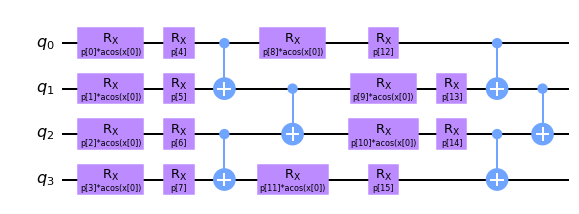

In [2]:
executor = Executor("qasm_simulator")
executor.set_shots(5000)

nqubits = 4
number_of_layers = 2

pqc = ChebyshevRx(nqubits, 1, num_layers=number_of_layers)
pqc.draw("mpl")

## Observable

In [3]:
op = SummedPaulis(nqubits)
print(op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


In [4]:
def sigmoid(x, a, b, c):
    return 1 / (1 + np.exp(-a * (x - b) / c))

In [5]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(13)
param_ini =  np.random.rand(pqc.num_parameters)
# Initialize parameters of the observable as ones
param_op_ini = np.random.rand(op.num_parameters)

x_train = np.arange(-1, 1.1, 0.1)
y_train = sigmoid(x_train, 5, 0, 1)

In [6]:
#x0 = [[i * 0.02] for i in range(15)]
x0 = [[1e-6], [2e-6], [1e-5], [2e-5]]
optimizer_options = {"bo_aqc_func": "EI", "bo_aqc_optimizer": "lbfgs", "bo_bounds": [(0.0, 0.2)], "log_file": "sglbo_sigmoid_noise_new.log",
                     "bo_n_calls": 60, "bo_x0_points": x0, "maxiter": 300, }

qnn_simulator_sglbo = QNNRegressor(
    pqc,
    op,
    executor,
    SquaredLoss(),
    SGLBO(optimizer_options),
    param_ini,
    param_op_ini=param_op_ini,
    opt_param_op=True, 
    parameter_seed=124
)

qnn_simulator_sglbo.fit(x_train, y_train)

fit:   0%|          | 0/300 [00:00<?, ?it/s]total_shots 3990000
gradient [-1.21570579  0.10676921  0.44520467 -4.0486516  -1.32466348  0.15807802
  0.66971096 -1.26648958  5.49556858  0.18800296 -0.8735175  -3.98527297
  1.91778453  0.16951861 -0.4086845  -1.31944906 -5.05633104  0.32335965
 -0.98372796 -0.66044858 -0.20040401]
finite_diff_grad [-9.48464557 -1.58701332  1.02771774 -4.60382976 -1.85683049  0.40691847
  1.71729279 -1.02765394  9.02268995  0.2887372  -2.47207634  0.32285364
 -0.15992538  9.3339111  -3.68983481 -4.52097554 -6.43997565  1.37671515
 -0.13278183 -4.1047854   6.95595798]
BOP  fval:  3.792190533876628  x:  [1e-06]
BOP  fval:  3.746010904323386  x:  [2e-06]
BOP  fval:  3.750209390668666  x:  [1e-05]
BOP  fval:  3.6569684153481052  x:  [2e-05]
BOP  fval:  11.785305713340584  x:  [0.19999418924994572]
BOP  fval:  3.508048739339528  x:  [0.0015828788262697777]
BOP  fval:  1.3671949983373248  x:  [0.03909966031750003]
BOP  fval:  0.8268417167264538  x:  [0.083595003

## predict vs. actual function